# Ensemble_CNN_BI_GRU Model

In [1]:
#Imports
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate, Bidirectional, GRU
from keras.models import Model
from keras.constraints import MaxNorm
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

##### 1)Loading Dataset

In [2]:
df=pd.read_csv("df_RandomDeletion.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,label,text,length,preprocessed_abstract,length_after_cleaning,tokenized_text
0,0,0,2,@VirginAmerica What @dhepburn said.,35,what say,8,"['what', 'say']"
1,1,1,1,@VirginAmerica plus you've added commercials t...,72,plus add commercial experience tacky,36,"['plus', 'add', 'commercial', 'experience', 't..."
2,2,2,2,@VirginAmerica I didn't today... Must mean I n...,71,i today must mean i need take another trip,42,"['i', 'today', 'must', 'mean', 'i', 'need', 't..."
3,3,3,0,@VirginAmerica it's really aggressive to blast...,126,really aggressive blast obnoxious entertainmen...,78,"['really', 'aggressive', 'blast', 'obnoxious',..."
4,4,4,0,@VirginAmerica and it's a really big bad thing...,55,really big bad thing,20,"['really', 'big', 'bad', 'thing']"


In [3]:
df.isnull().sum()

Unnamed: 0.1               0
Unnamed: 0                 0
label                      0
text                       0
length                     0
preprocessed_abstract    408
length_after_cleaning      0
tokenized_text             0
dtype: int64

In [4]:
df = df.dropna()

##### 2)Preparing Data

- Word2Vec model (pre-trained word embeddings) for embedding layer in the model

In [5]:
sentences = [sentence.split() for sentence in df['preprocessed_abstract']]
# Create and train the Word2Vec model
model_2= Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# Access the word vectors
word_vectors = model_2.wv
word_vectors.vectors

array([[ 8.8694537e-01, -2.4949664e-01,  8.6293286e-01, ...,
        -6.4027113e-01, -1.3692556e-01,  9.4257154e-02],
       [-4.1881245e-01,  5.6916755e-01,  1.1494361e+00, ...,
        -6.2736869e-01, -9.0696859e-01,  5.6412476e-01],
       [-9.0570755e-02,  4.4623104e-01, -6.2215287e-02, ...,
        -6.6735744e-01,  1.3193275e-01,  7.3047847e-02],
       ...,
       [ 3.4516780e-03,  1.0216033e-02,  1.2395979e-02, ...,
        -1.5539762e-02, -1.0174869e-02,  2.0757642e-02],
       [-8.7262196e-03,  1.2490608e-02, -4.9858312e-03, ...,
        -2.0480480e-03, -2.2606768e-03,  6.1931652e-03],
       [-9.9305334e-03, -2.7585134e-05,  8.6370306e-03, ...,
        -1.0169246e-02,  9.9075967e-03, -4.6164496e-05]], dtype=float32)

In [6]:
word_vectors.vectors.shape

(9391, 100)

#####  3) Split , into Training and Validation Sets (80:20)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_abstract'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)
print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (21700,) (21700,)
Test data: (5426,) (5426,)


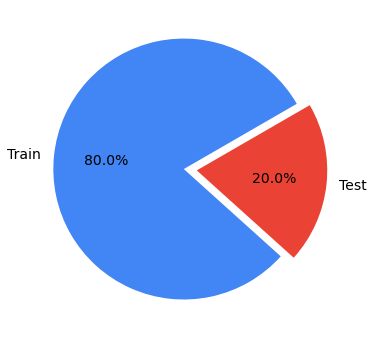

In [8]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(y_train), len(y_test)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0.05),
        startangle=30);

In [9]:
corp=X_train
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
max_length=max(len(d) for d in encoded_docs)
padded_docs_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_train)

[[  90   26    3 ...    0    0    0]
 [1268  658  206 ...    0    0    0]
 [  75  425 2057 ...    0    0    0]
 ...
 [   4    1 8737 ...    0    0    0]
 [  47   47   47 ...    0    0    0]
 [  59 2720  980 ...    0    0    0]]


In [10]:
corp=X_test
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
padded_docs_test = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_test)

[[   3 1340 2003 ...    0    0    0]
 [  13 1581  213 ...    0    0    0]
 [ 159  260   11 ...    0    0    0]
 ...
 [  51  603 1577 ...    0    0    0]
 [   4    0    0 ...    0    0    0]
 [  20  485    0 ...    0    0    0]]


##### 4)Model Architecture

In [11]:
def ensemble_CNN_BiGRU(filters=100, kernel_size=3, activation='relu',
                       input_dim=None, output_dim=100, max_length=None, emb_matrix=None, num_classes=None):

    # Channel 1D CNN
    input1 = Input(shape=(max_length,))
    embeddding1 = Embedding(input_dim=input_dim,
                            output_dim=output_dim,
                            input_length=max_length,
                            input_shape=(max_length,),
                            weights=[emb_matrix],
                            trainable=False)(input1)
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
                   kernel_constraint=MaxNorm(max_value=3, axis=[0, 1]))(embeddding1)
    pool1 = MaxPooling1D(pool_size=2, strides=2)(conv1)
    flat1 = Flatten()(pool1)
    drop1 = Dropout(0.5)(flat1)
    dense1 = Dense(10, activation='relu')(drop1)
    drop1 = Dropout(0.5)(dense1)
    out1 = Dense(num_classes, activation='softmax')(drop1)

    # Channel BiGRU
    input2 = Input(shape=(max_length,))
    embeddding2 = Embedding(input_dim=input_dim,
                            output_dim=output_dim,
                            input_length=max_length,
                            input_shape=(max_length,),
                            weights=[emb_matrix],
                            trainable=False,
                            mask_zero=True)(input2)
    gru2 = Bidirectional(GRU(64))(embeddding2)
    drop2 = Dropout(0.5)(gru2)
    out2 = Dense(num_classes, activation='softmax')(drop2)

    # Merge
    merged = concatenate([out1, out2])

    # Interpretation
    outputs = Dense(num_classes, activation='softmax')(merged)
    model = Model(inputs=[input1, input2], outputs=outputs)

    # Compile with sparse categorical crossentropy
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

In [12]:
model = ensemble_CNN_BiGRU(input_dim=word_vectors.vectors.shape[0], output_dim=100, max_length=max_length, emb_matrix=word_vectors.vectors, num_classes=3)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 26)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 26, 100)              939100    ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 24, 100)              30100     ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 12, 100)              0         ['conv1d[0][0]']              
 D)                                                                                         

##### 5) Training Model

In [13]:
history=model.fit([padded_docs_train, padded_docs_train], y_train, epochs=100, batch_size=100, validation_data=([padded_docs_test,padded_docs_test], y_test))
history

Epoch 1/100


217/217 [==============================] - 100s 157ms/step - loss: 1.0201 - accuracy: 0.4874 - val_loss: 1.0001 - val_accuracy: 0.5177
Epoch 2/100
217/217 [==============================] - 9s 40ms/step - loss: 0.9690 - accuracy: 0.5440 - val_loss: 0.9774 - val_accuracy: 0.5273
Epoch 3/100
217/217 [==============================] - 9s 42ms/step - loss: 0.9331 - accuracy: 0.5742 - val_loss: 0.9624 - val_accuracy: 0.5426
Epoch 4/100
217/217 [==============================] - 8s 39ms/step - loss: 0.9047 - accuracy: 0.5929 - val_loss: 0.9694 - val_accuracy: 0.5299
Epoch 5/100
217/217 [==============================] - 9s 40ms/step - loss: 0.8863 - accuracy: 0.6035 - val_loss: 0.9758 - val_accuracy: 0.5286
Epoch 6/100
217/217 [==============================] - 9s 39ms/step - loss: 0.8711 - accuracy: 0.6162 - val_loss: 0.9745 - val_accuracy: 0.5346
Epoch 7/100
217/217 [==============================] - 9s 40ms/step - loss: 0.8490 - accuracy: 0.6304 - val_loss: 0.9889 - val_accu

217/217 [==============================] - 7s 31ms/step - loss: 0.3611 - accuracy: 0.8759 - val_loss: 1.5385 - val_accuracy: 0.4934
Epoch 55/100
217/217 [==============================] - 6s 29ms/step - loss: 0.3542 - accuracy: 0.8789 - val_loss: 1.5427 - val_accuracy: 0.4897
Epoch 56/100
217/217 [==============================] - 6s 28ms/step - loss: 0.3472 - accuracy: 0.8812 - val_loss: 1.5490 - val_accuracy: 0.4891
Epoch 57/100
217/217 [==============================] - 6s 28ms/step - loss: 0.3449 - accuracy: 0.8828 - val_loss: 1.5684 - val_accuracy: 0.4884
Epoch 58/100
217/217 [==============================] - 6s 28ms/step - loss: 0.3463 - accuracy: 0.8804 - val_loss: 1.5584 - val_accuracy: 0.4891
Epoch 59/100
217/217 [==============================] - 6s 28ms/step - loss: 0.3460 - accuracy: 0.8802 - val_loss: 1.5980 - val_accuracy: 0.4806
Epoch 60/100
217/217 [==============================] - 6s 28ms/step - loss: 0.3283 - accuracy: 0.8875 - val_loss: 1.6161 - val_accuracy: 0.485

##### 6) Finding Training and Testing Accuracy

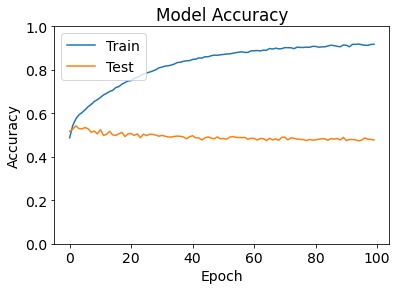

In [14]:
# Plot the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
test_loss,test_acc=model.evaluate([padded_docs_test,padded_docs_test],y_test)
test_loss,test_acc

170/170 [==============================] - 1s 6ms/step - loss: 1.8369 - accuracy: 0.4771


(1.83685302734375, 0.47714707255363464)

##### 7) Compute and plot the confusion matrix for the three classes

In [16]:
predictions=model.predict([padded_docs_test,padded_docs_test])
class_labels = ['negative', 'positive','neutral']
predicted_class_labels = [class_labels[np.argmax(pred)] for pred in predictions]
actual_class_labels=[class_labels[actual] for actual in y_test]
print(classification_report(actual_class_labels, predicted_class_labels))

170/170 [==============================] - 3s 6ms/step
              precision    recall  f1-score   support

    negative       0.46      0.51      0.48      1835
     neutral       0.45      0.48      0.47      1801
    positive       0.54      0.44      0.49      1790

    accuracy                           0.48      5426
   macro avg       0.48      0.48      0.48      5426
weighted avg       0.48      0.48      0.48      5426



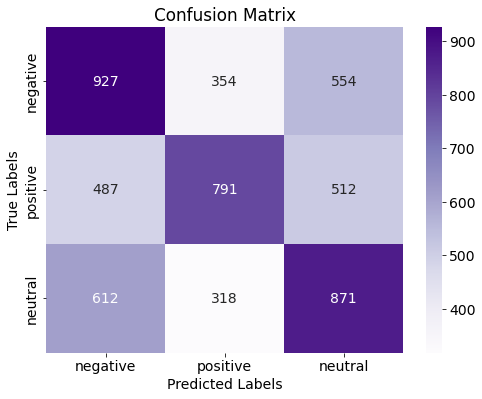

In [17]:
conf_matrix = confusion_matrix(actual_class_labels, predicted_class_labels, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 8) Saving the final results in Excel sheet

In [18]:
precision_per_class = precision_score(actual_class_labels, predicted_class_labels, average=None)
recall_per_class = recall_score(actual_class_labels, predicted_class_labels, average=None)

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

Precision per class: [0.45755183 0.44966443 0.54066986]
Recall per class: [0.50517711 0.48362021 0.44189944]


In [19]:
f1_micro = f1_score(actual_class_labels, predicted_class_labels, average='micro')
f1_macro = f1_score(actual_class_labels, predicted_class_labels, average='macro')

print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)

Micro F1 Score: 0.477147069664578
Macro F1 Score: 0.47751047066113195


In [23]:
result=pd.read_csv('Ensemble_CNN-GRU_ModelResults.csv')
result['RandomDeletion_Dataset']=[max(history.history['accuracy']),test_acc,f1_micro,f1_macro,precision_per_class[0],precision_per_class[1],precision_per_class[2],recall_per_class[0],recall_per_class[1],recall_per_class[2]]
result[['Unnamed: 0','RandomDeletion_Dataset']]

,Unnamed: 0,RandomDeletion_Dataset
0,Training Accuracy,0.918710
1,Testing Accuracy,0.477147
2,Micro F1 Score,0.477147
3,Macro F1 Score,0.477510
4,Precision for Negative sentiment,0.457552
5,Precision for Positive sentiment,0.449664
6,Precision for Neutral sentiment,0.540670
7,Recall for Negative sentiment,0.505177
8,Recall for Positive sentiment,0.483620
9,Recall for Neutral sentiment,0.441899


In [24]:
result.to_csv('Ensemble_CNN-GRU_ModelResults.csv', index=False)